# Testing the effects of synapse and scaling_firing_rates on the accuracy of a converted spiking deep network.

## Initialize data

In [1]:
import matplotlib.pyplot as plt
import nengo
import numpy as np
import tensorflow as tf
import nengo_dl

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [2]:
tf.keras.backend.clear_session()

In [3]:
# obtain images
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.cifar10.load_data()

# normalize data by color channel
def normalize(array):
    return (array - np.mean(array)) / np.std(array)

train_images_R = normalize(train_images.transpose()[0].transpose())
train_images_G = normalize(train_images.transpose()[1].transpose())
train_images_B = normalize(train_images.transpose()[2].transpose())
test_images_R = normalize(test_images.transpose()[0].transpose())
test_images_G = normalize(test_images.transpose()[1].transpose())
test_images_B = normalize(test_images.transpose()[2].transpose())

train_images = np.array([train_images_R, train_images_G, train_images_B])
test_images = np.array([test_images_R, test_images_G, test_images_B])

train_images = np.moveaxis(train_images, 0, -1)
test_images = np.moveaxis(test_images, 0, -1)

# verify normalization
print((train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape))
print('test mean:', np.mean(train_images))
print('test stdv:', np.std(train_images))
print('train mean:', np.mean(test_images))
print('train stdv:', np.std(test_images))

((50000, 32, 32, 3), (50000, 1)) ((10000, 32, 32, 3), (10000, 1))
test mean: 5.4830214442821065e-17
test stdv: 1.0000000000000002
train mean: 8.14903700074865e-18
train stdv: 1.0000000000000002


In [4]:
# flatten images and add time dimension
train_images = train_images.reshape((train_images.shape[0], 1, -1))
train_labels = train_labels.reshape((train_labels.shape[0], 1, -1))
test_images = test_images.reshape((test_images.shape[0], 1, -1))
test_labels = test_labels.reshape((test_labels.shape[0], 1, -1))

print((train_images.shape, train_labels.shape), (test_images.shape, test_labels.shape))

((50000, 1, 3072), (50000, 1, 1)) ((10000, 1, 3072), (10000, 1, 1))


## Build network and convert to nengo-dl

In [5]:
inp = tf.keras.Input(shape=(32, 32, 3))

flatten = tf.keras.layers.Flatten()(inp)

# reduced to 200 neurons per layer (75 was too low)
dense0 = tf.keras.layers.Dense(units=204, activation=tf.nn.relu, name='d0')(flatten)
dense1 = tf.keras.layers.Dense(units=203, activation=tf.nn.relu, name='d1')(dense0)
dense2 = tf.keras.layers.Dense(units=202, activation=tf.nn.relu, name='d2')(dense1)
dense3 = tf.keras.layers.Dense(units=201, activation=tf.nn.relu, name='d3')(dense2)
dense4 = tf.keras.layers.Dense(units=200, activation=tf.nn.relu, name='d4')(dense3)

out = tf.keras.layers.Dense(units=10)(dense4)

model = tf.keras.Model(inputs=inp, outputs=out)

In [6]:
converter = nengo_dl.Converter(model)

## Train the non-spiking network

In [7]:
with nengo_dl.Simulator(converter.net, minibatch_size=200) as sim:
    
    sim.compile(
        optimizer=tf.optimizers.Adam(0.001),
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.metrics.sparse_categorical_accuracy]
    )

    sim.fit(
        {converter.inputs[inp]: train_images},
        {converter.outputs[out]: train_labels},
        validation_data=({converter.inputs[inp]: test_images}, {converter.outputs[out]: test_labels}),
        epochs=20
    )

    # save the parameters
    sim.save_params("./equal_dnn_params")

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
Epoch 1/20
250/250 [==============================] - 7s 19ms/step - loss: 1.8235 - probe_loss: 1.8235 - probe_sparse_categorical_accuracy: 0.3453 - val_loss: 1.5512 - val_probe_loss: 1.5512 - val_probe_sparse_categorical_accuracy: 0.4483
Epoch 2/20
250/250 [==============================] - 4s 16ms/step - loss: 1.4836 - probe_loss: 1.4836 - probe_sparse_categorical_accuracy: 0.4724 - val_loss: 1.4345 - val_probe_loss: 1.4345 - val_probe_sparse_categorical_accuracy: 0.4901
Epoch 3/20
250/250 [==============================] - 4s 16ms/step - loss: 1.3652 - probe_loss: 1.3652 - probe_sparse_categorical_accuracy: 0.5158 - val_loss: 1.4359 - val_probe_loss: 1.4359 - val_probe_sparse_categorical_accuracy: 0.4898
Epoch 4/20
250/250 [=======================

## Run the non-spiking network

In [8]:
def run_network(
    activation,
    params_file="equal_dnn_params",
    n_steps=30,
    scale_firing_rates=1,
    synapse=None,
    n_test=400,
):
    # convert the keras model to a nengo network
    nengo_converter = nengo_dl.Converter(
        model,
        swap_activations={tf.nn.relu: activation},
        scale_firing_rates=scale_firing_rates,
        synapse=synapse,
    )

    # get input/output objects
    nengo_input = nengo_converter.inputs[inp]
    nengo_output = nengo_converter.outputs[out]

    # repeat inputs for some number of timesteps
    tiled_test_images = np.tile(test_images[:n_test], (1, n_steps, 1))

    # set some options to speed up simulation
    with nengo_converter.net:
        nengo_dl.configure_settings(stateful=False)

    # build network, load in trained weights, run inference on test images
    with nengo_dl.Simulator(
        nengo_converter.net, minibatch_size=10, progress_bar=False
    ) as nengo_sim:
        nengo_sim.load_params(params_file)
        data = nengo_sim.predict({nengo_input: tiled_test_images})

    # compute accuracy on test data, using output of network on
    # last timestep
    predictions = np.argmax(data[nengo_output][:, -1], axis=-1)
    accuracy = (predictions == test_labels[:n_test, 0, 0]).mean()
    print(f"    Test accuracy: {100 * accuracy:.2f}%")

    return accuracy

In [9]:
baseline_accuracy = run_network(activation=nengo.RectifiedLinear(), n_steps=10)

    Test accuracy: 53.00%


## Apply synaptic smoothing and scale firing rates

In [10]:
# specify the size of the grid: (synapse, scale_firing_rates)
grid_size = (5, 10)
scaling_baseline = 1
synapse_increment = 0.005

synapse_values = [synapse_increment*x for x in range(grid_size[0])]
scale_firing_rates_values = range(1, 81, 10)
accuracy_grid = []

for synapse in synapse_values:
    print(f"synapse={synapse:.3f}")
    accuracy_grid.append([])

    for scale_firing_rates in scale_firing_rates_values:
        print(f"  scale_firing_rates={scale_firing_rates:.3f}")
        accuracy = run_network(
            activation=nengo.SpikingRectifiedLinear(),
            n_steps=60,
            synapse=synapse,
            scale_firing_rates=scale_firing_rates)         
        accuracy_grid[-1].append(accuracy)

synapse=0.000
  scale_firing_rates=1.000
    Test accuracy: 8.75%
  scale_firing_rates=11.000
    Test accuracy: 14.25%
  scale_firing_rates=21.000
    Test accuracy: 13.75%
  scale_firing_rates=31.000
    Test accuracy: 17.25%
  scale_firing_rates=41.000
    Test accuracy: 21.50%
  scale_firing_rates=51.000
    Test accuracy: 20.75%
  scale_firing_rates=61.000
    Test accuracy: 28.25%
  scale_firing_rates=71.000
    Test accuracy: 28.50%
synapse=0.005
  scale_firing_rates=1.000
    Test accuracy: 7.50%
  scale_firing_rates=11.000
    Test accuracy: 33.75%
  scale_firing_rates=21.000
    Test accuracy: 40.75%
  scale_firing_rates=31.000
    Test accuracy: 46.00%
  scale_firing_rates=41.000
    Test accuracy: 45.50%
  scale_firing_rates=51.000
    Test accuracy: 45.50%
  scale_firing_rates=61.000
    Test accuracy: 46.25%
  scale_firing_rates=71.000
    Test accuracy: 46.50%
synapse=0.010
  scale_firing_rates=1.000
    Test accuracy: 7.50%
  scale_firing_rates=11.000
    Test accuracy:

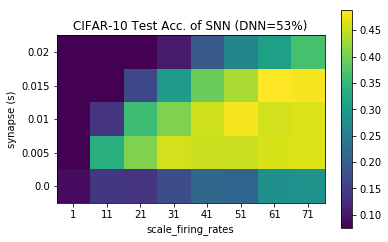

In [16]:
accuracy_grid = np.matrix(accuracy_grid)

fig, ax = plt.subplots(1,1)

plt.xlabel("scale_firing_rates")
plt.ylabel("synapse (s)")
plt.title("CIFAR-10 Test Acc. of SNN (DNN=53%)")

ax.set_xticklabels([1] + [1, 11, 21, 31, 41, 51, 61, 71])
ax.set_yticklabels([0] + [synapse_increment*s for s in range(grid_size[0])])

img = ax.imshow(accuracy_grid, origin='lower')
fig.colorbar(img)
plt.savefig("./images/reduced_dense_accuracy_grid", dpi=400)